In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

# load data

In [2]:
import pickle

data_index = pickle.load(open('../input/upsamplekfoldindex/data_index.p', 'rb'))

In [3]:
beeap_1 = pd.read_csv('../input/beeapfinal/beeap_1.csv')
beeap_1.drop('Unnamed: 0', axis=1, inplace=True)
for i in beeap_1.columns[1:]:
    beeap_1[i] = beeap_1[i].astype(np.float64, errors='ignore')
print(beeap_1.shape)
beeap_1.head()

(1702, 26)


,Index,Email,Message-ID,Date,From,To,Subject,Cc,Mime-Version,Content-Type,Content-Transfer-Encoding,Bcc,X-From,X-To,X-cc,X-Folder,X-Origin,X-FileName,Content,1,2,3,4,5,6,Contents
0,10425,Message-ID: <197504.1075840201539.JavaMail.eva...,<197504.1075840201539.JavaMail.evans@thyme>,"Mon, 18 Oct 1999 01:47:00 -0700 (PDT)",steven.kean@enron.com,"mark.schroeder@enron.com, kenneth.lay@enron.co...",Translation of articles,NaN,1.0,text/plain; charset=us-ascii,7bit,NaN,Steven J Kean,"Mark Schroeder, Kenneth Lay, Joseph W Sutton, ...",NaN,\Kenneth_Lay_Dec2000\Notes Folders\All documents,LAY-K,klay.nsf,forwarded by steven j kean hou ees on am kare...,1.0,0.0,0.0,0.0,0.0,0.0,message id javamail evans@thyme date mon oct p...
1,106296,Message-ID: <11991339.1075842536086.JavaMail.e...,<11991339.1075842536086.JavaMail.evans@thyme>,"Mon, 5 Mar 2001 08:23:00 -0800 (PST)",drew.fossum@enron.com,darrell.schoolcraft@enron.com,TW Gas Sales: PRIVILEGED AND CONFIDENTIAL ATTO...,"danny.mccarty@enron.com, steven.harris@enron.c...",1.0,text/plain; charset=us-ascii,7bit,"danny.mccarty@enron.com, steven.harris@enron.c...",Drew Fossum,Darrell Schoolcraft,"Danny McCarty, Steven Harris, Kevin Hyatt",\Drew_Fossum_Dec2000_June2001_2\Notes Folders\...,FOSSUM-D,dfossum.nsf,in anticipation of potential litigation involv...,1.0,0.0,0.0,0.0,0.0,0.0,message id javamail evans@thyme date mon mar p...
2,106298,Message-ID: <7106753.1075842536132.JavaMail.ev...,<7106753.1075842536132.JavaMail.evans@thyme>,"Tue, 6 Mar 2001 00:59:00 -0800 (PST)",drew.fossum@enron.com,"julia.white@enron.com, steven.january@enron.com",TW Gas Sales: PRIVILEGED AND CONFIDENTIAL ATTO...,darrell.schoolcraft@enron.com,1.0,text/plain; charset=us-ascii,7bit,darrell.schoolcraft@enron.com,Drew Fossum,"Julia White, Steven January",Darrell Schoolcraft,\Drew_Fossum_Dec2000_June2001_2\Notes Folders\...,FOSSUM-D,dfossum.nsf,julia and steve here are some questions i ve s...,1.0,0.0,0.0,0.0,0.0,1.0,message id javamail evans@thyme date tue mar p...
3,106588,Message-ID: <21267718.1075863331587.JavaMail.e...,<21267718.1075863331587.JavaMail.evans@thyme>,"Tue, 6 Mar 2001 11:59:00 -0800 (PST)",drew.fossum@enron.com,"julia.white@enron.com, steven.january@enron.com",TW Gas Sales: PRIVILEGED AND CONFIDENTIAL ATTO...,darrell.schoolcraft@enron.com,1.0,text/plain; charset=us-ascii,7bit,darrell.schoolcraft@enron.com,Drew Fossum,"Julia White <Julia White/ET&S/Enron@ENRON>, St...",Darrell Schoolcraft <Darrell Schoolcraft/ET&S/...,"\DFOSSUM (Non-Privileged)\Fossum, Drew\'Sent Mail",Fossum-D,DFOSSUM (Non-Privileged).pst,julia and steve here are some questions i ve s...,1.0,0.0,0.0,0.0,0.0,0.0,message id javamail evans@thyme date tue mar p...
4,106590,Message-ID: <20866019.1075863331634.JavaMail.e...,<20866019.1075863331634.JavaMail.evans@thyme>,"Mon, 5 Mar 2001 19:23:00 -0800 (PST)",drew.fossum@enron.com,darrell.schoolcraft@enron.com,TW Gas Sales: PRIVILEGED AND CONFIDENTIAL ATTO...,"danny.mccarty@enron.com, steven.harris@enron.c...",1.0,text/plain; charset=us-ascii,7bit,"danny.mccarty@enron.com, steven.harris@enron.c...",Drew Fossum,Darrell Schoolcraft <Darrell Schoolcraft/ET&S/...,Danny McCarty <Danny McCarty/ET&S/Enron@Enron>...,"\DFOSSUM (Non-Privileged)\Fossum, Drew\'Sent Mail",Fossum-D,DFOSSUM (Non-Privileged).pst,in anticipation of potential litigation involv...,1.0,0.0,0.0,0.0,0.0,0.0,message id javamail evans@thyme date mon mar p...


# Model

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def main(data_set, embedding_path, data_index=None, content_column='contents', label_column='labels', max_len=200, max_features=100000, embed_size=300):

    """
    Input:
    data_set: pandas DataFrame that contains text contents and labels
    embedding_path: word embedding saving path
    data_index: list of np.array that contains the training, validation, and test indeces
    content_column: Name of content column, default is 'contents'
    label_column: Name of label column(s), default is 'labels'
    max_len: the padding lenth of the text, default is 200
    max_features: Maximum number of words recognized by the model, default is 100000
    embed_size: length of embedding vector, should correspond with the embedding provided, default is 300
    """

    # Build dictionary from word embedding
    print('Loading word vectors...')
    #word2vec = {}
    #with tqdm(open(embedding_path)) as f:
    #with open(embedding_path) as f:
    #    for line in f:
    #        values = line.split()
    #        word = values[0]
    #        vec = np.asarray(values[1:], dtype='float32')
    #        word2vec[word] = vec
    
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    word2vec = dict(get_coefs(*o.strip().split(" ")) for o in tqdm(open(embedding_path)))
    
    print('Found %s word vectors.' % len(word2vec))

    # prepare text samples and their labels
    print('Loading in comments...')
    # extract the comments, fill NaN with some values
    contents = data_set[content_column].fillna("DUMMY_VALUE").values
    labels = data_set[label_column].values
    
    if data_index == None:
        X_train, X_test, y_train, y_test = train_test_split(contents, labels, test_size = 0.2, random_state=0)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.125, random_state=0)
    else:
        X_train = contents[data_index[0]]
        y_train = labels[data_index[0]]
        X_valid = contents[data_index[1]]
        y_valid = labels[data_index[1]]
        X_test = contents[data_index[2]]
        y_test = labels[data_index[2]]

    # convert the sentences (strings) into integers, thus they can be used as index later on
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(X_train)
    #sequences = tokenizer.texts_to_sequences(sentences)
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_valid_seq = tokenizer.texts_to_sequences(X_valid)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    print("max sequence length:", max(len(s) for s in X_train_seq))
    print("min sequence length:", min(len(s) for s in X_train_seq))
    s = sorted(len(s) for s in X_train_seq)
    print("median sequence length:", s[len(s) // 2])

    # get word -> integer mapping
    word2idx = tokenizer.word_index
    print('Found %s unique tokens.' % len(word2idx))

    # pad sequences so that we get a N x T matrix
    # Keras take care of the 0 only for padding purpose 
    #data = pad_sequences(sequences, maxlen=max_len)
    X_train = pad_sequences(X_train_seq, maxlen=max_len)
    X_valid = pad_sequences(X_valid_seq, maxlen=max_len)
    X_test = pad_sequences(X_test_seq, maxlen=max_len)
    print('Shape of data tensor:', X_train.shape)

    # prepare embedding matrix
    print('Filling pre-trained embeddings...')
    num_words = min(max_features, len(word2idx) + 1)
    embedding_matrix = np.zeros((num_words, embed_size))
    for word, i in word2idx.items():
        if i < max_features:
            embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
          # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

    # load pre-trained word embeddings into an Embedding layer
    # note that we set trainable = False so as to keep the embeddings fixed
    embedding_layer = Embedding(
      min(max_features, embedding_matrix.shape[0]),
      embed_size,
      weights=[embedding_matrix],
      input_length=max_len,
        # don't want to make the embeddding updated during the procedure
      trainable=False
    )

    return X_train, y_train, X_valid, y_valid, X_test, y_test, embedding_layer

Using TensorFlow backend.


In [5]:
X_train, y_train, X_valid, y_valid, X_test, y_test, embedding_layer = main(beeap_1, '../input/glove-6b/glove.6B.300d.txt', data_index=[data_index['train'][0], data_index['val'][0], data_index['test']], content_column='Contents', label_column=[str(i+1) for i in range(6)])

1035it [00:00, 9744.10it/s]

Loading word vectors...


400000it [00:32, 12210.59it/s]


Found 400000 word vectors.
Loading in comments...
max sequence length: 36540
min sequence length: 58
median sequence length: 303
Found 26969 unique tokens.
Shape of data tensor: (34040, 200)
Filling pre-trained embeddings...


In [6]:
import logging
from sklearn.metrics import roc_auc_score, f1_score
from keras.callbacks import Callback

class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [7]:
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import Dense, Input, CuDNNLSTM, CuDNNGRU, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer

arguments = {
    'max_len': 200,
    'batch_size': 128,
    'epochs': 50,
    'learning_rate': 1e-3,
    'learning_rate_decay': 0,
    'units': 128,
    'drop_out_rate': 0.2,
    'checkpoint_path': 'best_model.hdf5',
    'early_stop_patience': 3,
}

def build_lstm_model(X_train, y_train, X_valid, y_valid, arguments):

    print('Building model...')

    file_path = arguments['checkpoint_path']
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    ra_val = RocAucEvaluation(validation_data=(X_valid, y_valid), interval = 1)
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = arguments['early_stop_patience'])
    
    inp = Input(shape=(arguments['max_len'],))
    x = embedding_layer(inp)
    x = CuDNNLSTM(arguments['units'], return_sequences=True, name='lstm_layer')(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(arguments['drop_out_rate'])(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(arguments['drop_out_rate'])(x)
    # using sigmoid since we are doing six binary classifications
    if y_train.ndim == 2:
        output = Dense(y_train.shape[1], activation='sigmoid')(x)
    else:
        output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs = inp, outputs = output)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = arguments['learning_rate'], decay = arguments['learning_rate_decay']),\
                  metrics = ["accuracy"])
    history = model.fit(X_train, y_train, batch_size = arguments['batch_size'], epochs = arguments['epochs'],\
                        validation_data = (X_valid, y_valid), verbose = 1, callbacks = [ra_val, check_point, early_stop])
    model = load_model(file_path)
    return model

In [8]:
def build_bilstm_model(X_train, y_train, X_valid, y_valid, arguments):

    print('Building model...')

    file_path = arguments['checkpoint_path']
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    ra_val = RocAucEvaluation(validation_data=(X_valid, y_valid), interval = 1)
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = arguments['early_stop_patience'])

    inp = Input(shape=(arguments['max_len'],))
    x = embedding_layer(inp)
    x1 = SpatialDropout1D(arguments['drop_out_rate'])(x)
    x = Bidirectional(CuDNNGRU(arguments['units'], return_sequences = True))(x1)
    x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
    y = Bidirectional(CuDNNLSTM(arguments['units'], return_sequences = True))(x1)
    y = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(y)
    avg_pool1 = GlobalAveragePooling1D()(x)
    max_pool1 = GlobalMaxPooling1D()(x)
    avg_pool2 = GlobalAveragePooling1D()(y)
    max_pool2 = GlobalMaxPooling1D()(y)
    x = concatenate([avg_pool1, max_pool1, avg_pool2, max_pool2])
    if y_train.ndim == 2:
        output = Dense(y_train.shape[1], activation='sigmoid')(x)
    else:
        output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs = inp, outputs = output)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = arguments['learning_rate'], decay = arguments['learning_rate_decay']),\
                  metrics = ["accuracy"])
    history = model.fit(X_train, y_train, batch_size = arguments['batch_size'], epochs = arguments['epochs'],\
                        validation_data = (X_valid, y_valid), verbose = 1, callbacks = [ra_val, check_point, early_stop])
    model = load_model(file_path)
    return model

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, y_pred, title=None, micro=False, macro=True, per_class=False):

    if y_train.ndim == 2:
        num_instances, num_classes = y_train.shape
    else:
        num_instances = y_train.shape[0]
        num_classes = 1
    if (num_classes != 2) and (y_test.ndim == 1):
        bi_y_test = label_binarize(y_test, classes=range(num_classes))
    else:
        bi_y_test = y_test
    
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(bi_y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

    # Compute macro-average ROC curve and AUC
    # Aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    # Interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Average and compute AUC
    mean_tpr /= num_classes

    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

    # Plot all ROC curves
    plt.figure(figsize=(10, 10))
    if micro == True:
        plt.plot(fpr['micro'], tpr['micro'],
                 label='micro-average ROC curve (area = {0:0.4f})'
                       ''.format(roc_auc['micro']),
                 color='orangered', linestyle=':', linewidth=3)

    if macro == True:
        plt.plot(fpr['macro'], tpr['macro'],
                 label='macro-average ROC curve (area = {0:0.4f})'
                       ''.format(roc_auc['macro']),
                 color='navy', linestyle=':', linewidth=3)

    if per_class == True:
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], alpha=0.2,
                     label='ROC curve of class {0} (area = {1:0.4f})'
                     ''.format(i+1, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=13)
    plt.xticks(fontsize=13)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    if type(title) == str:
        plt.title(title, fontsize=16)
    elif title != None:
        print('Title must be a string.')
        plt.title('ROC Curves', fontsize=16)
    else:
        plt.title('ROC Curves', fontsize=16)
    plt.legend(loc=4)
    plt.show()

In [10]:
from sklearn.tree import DecisionTreeClassifier

def pred_classes_dt(y_train_pred, y_train, y_test_pred):
    if y_train.ndim == 2:
        num_instances, num_classes = y_train.shape
    else:
        num_instances = y_train.shape[0]
        num_classes = 1
    threshold = []
    for i in range(num_classes):
        if num_classes == 1:
            clf = DecisionTreeClassifier(max_depth=1)
            clf.fit(y_train_pred[:, i].reshape(-1, 1), y_train[:, i])
            threshold += [clf.tree_.threshold[0]]
        else:
            clf = DecisionTreeClassifier(max_depth=1)
            clf.fit(y_train_pred[:, i].reshape(-1, 1), y_train[:, i])
            threshold += [clf.tree_.threshold[0]]
    pred_classes = y_test_pred >= threshold
    return pred_classes.astype(int)

In [11]:
from sklearn.metrics import precision_recall_curve

def pred_classes_f1(y_train_pred, y_train, y_test_pred):
    if y_train.ndim == 2:
        num_instances, num_classes = y_train.shape
    else:
        num_instances = y_train.shape[0]
        num_classes = 1
    threshold = []
    for i in range(num_classes):
        if num_classes == 1:
            precision, recall, thresholds = precision_recall_curve(y_train, train_pred)
            f1 = 2 * precision * recall / (precision + recall)
            threshold += [thresholds[np.argmax(f1)]]
        else:
            precision, recall, thresholds = precision_recall_curve(y_train[:, i], train_pred[:, i])
            f1 = 2 * precision * recall / (precision + recall)
            threshold += [thresholds[np.argmax(f1)]]
    pred_classes = y_test_pred >= threshold
    return pred_classes.astype(int)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, title=None, x_classes=None, y_classes=None):
    if y_pred.ndim != 1:
        print("y_pred don't accept probability, and please don't binarize")
    cm = confusion_matrix(y_test, y_pred)
    num_classes = cm.shape[0]
    count = np.unique(y_test, return_counts=True)[1].reshape(num_classes, 1)
    if 0 in count:
        print('Detect 0 value in True Label, please double check')

    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    im = ax.imshow(cm/count, cmap='YlGnBu')
    im.set_clim(0, 1)
    cbar = ax.figure.colorbar(im, ax=ax)
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    if type(x_classes) == list:
        ax.set_xticklabels(x_classes, set_rotation(45))
    if type(y_classes) == list:
        ax.set_yticklabels(y_classes)
    plt.yticks(fontsize=13)
    plt.xticks(fontsize=13)
    for i in range(num_classes):
        for j in range(num_classes):
            text = ax.text(i, j, cm[j][i], ha="center", va="center", color="w" if (cm/count)[j, i] > 0.5 else "black", fontsize=13)
    ax.set_ylabel('True Label', fontsize=16)
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_title('Confusion Matrix for Coarse Genre', fontsize=16, fontweight='bold')
    plt.show()

---

# Example

In [13]:
predictions = []
for i in range(3):
    X_train, y_train, X_valid, y_valid, X_test, y_test, embedding_layer = main(beeap_1, '../input/glove-6b/glove.6B.300d.txt', data_index=[data_index['train'][i], data_index['val'][i], data_index['test']], content_column='Contents', label_column=[str(i+1) for i in range(6)])
    model =  build_bilstm_model(X_train, y_train, X_valid, y_valid, arguments)
    pred = model.predict(X_test, batch_size = arguments['batch_size'], verbose = 1)
    predictions += [pred]

1522it [00:00, 15217.55it/s]

Loading word vectors...


400000it [00:32, 12478.33it/s]


Found 400000 word vectors.
Loading in comments...
max sequence length: 36540
min sequence length: 58
median sequence length: 303
Found 26969 unique tokens.
Shape of data tensor: (34040, 200)
Filling pre-trained embeddings...
Building model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 34040 samples, validate on 227 samples
Epoch 1/50
34040/34040 [==============================] - 24s 697us/step - loss: 0.2032 - acc: 0.9205 - val_loss: 0.2935 - val_acc: 0.8928

 ROC-AUC - epoch: 1 - score: 0.859708

Epoch 00001: val_loss improved from inf to 0.29346, saving model to best_model.hdf5
Epoch 2/50
34040/34040 [==============================] - 19s 564us/step - loss: 0.0395 - acc: 0.9884 - val_loss: 0.4477 - val_acc: 0

1045it [00:00, 10449.54it/s]

Loading word vectors...


400000it [00:32, 12492.28it/s]


Found 400000 word vectors.
Loading in comments...
max sequence length: 36540
min sequence length: 58
median sequence length: 296
Found 25931 unique tokens.
Shape of data tensor: (34040, 200)
Filling pre-trained embeddings...
Building model...
Train on 34040 samples, validate on 227 samples
Epoch 1/50
34040/34040 [==============================] - 21s 619us/step - loss: 0.2054 - acc: 0.9181 - val_loss: 0.3382 - val_acc: 0.8979

 ROC-AUC - epoch: 1 - score: 0.819940

Epoch 00001: val_loss improved from inf to 0.33817, saving model to best_model.hdf5
Epoch 2/50
34040/34040 [==============================] - 19s 563us/step - loss: 0.0405 - acc: 0.9881 - val_loss: 0.4459 - val_acc: 0.8847

 ROC-AUC - epoch: 2 - score: 0.807754

Epoch 00002: val_loss did not improve from 0.33817
Epoch 3/50
34040/34040 [==============================] - 19s 566us/step - loss: 0.0217 - acc: 0.9930 - val_loss: 0.5226 - val_acc: 0.8869

 ROC-AUC - epoch: 3 - score: 0.800691

Epoch 00003: val_loss did not improve

2512it [00:00, 12617.76it/s]

Loading word vectors...


400000it [00:31, 12590.64it/s]


Found 400000 word vectors.
Loading in comments...
max sequence length: 33773
min sequence length: 58
median sequence length: 298
Found 26054 unique tokens.
Shape of data tensor: (34040, 200)
Filling pre-trained embeddings...
Building model...
Train on 34040 samples, validate on 227 samples
Epoch 1/50
34040/34040 [==============================] - 22s 636us/step - loss: 0.2044 - acc: 0.9202 - val_loss: 0.3197 - val_acc: 0.8825

 ROC-AUC - epoch: 1 - score: 0.858412

Epoch 00001: val_loss improved from inf to 0.31972, saving model to best_model.hdf5
Epoch 2/50
34040/34040 [==============================] - 19s 569us/step - loss: 0.0424 - acc: 0.9870 - val_loss: 0.4760 - val_acc: 0.8767

 ROC-AUC - epoch: 2 - score: 0.847126

Epoch 00002: val_loss did not improve from 0.31972
Epoch 3/50
34040/34040 [==============================] - 19s 568us/step - loss: 0.0243 - acc: 0.9913 - val_loss: 0.4975 - val_acc: 0.8862

 ROC-AUC - epoch: 3 - score: 0.854187

Epoch 00003: val_loss did not improve

In [14]:
train_pred = model.predict(X_train, batch_size = 1024, verbose = 1)
y_pred_dt = pred_classes_dt(train_pred, y_train, np.average(predictions, axis=0))
print('macro F1 score: {0:0.4f}'.format(f1_score(y_test, y_pred_dt, average='macro')))
print('micro F1 score: {0:0.4f}'.format(f1_score(y_test, y_pred_dt, average='micro')))

y_pred_f1 = pred_classes_f1(train_pred, y_train, np.average(predictions, axis=0))
print('macro F1 score: {0:0.4f}'.format(f1_score(y_test, y_pred_f1, average='macro')))
print('micro F1 score: {0:0.4f}'.format(f1_score(y_test, y_pred_f1, average='micro')))

34040/34040 [==============================] - 4s 104us/step
macro F1 score: 0.5196
micro F1 score: 0.6803
macro F1 score: 0.5133
micro F1 score: 0.6804


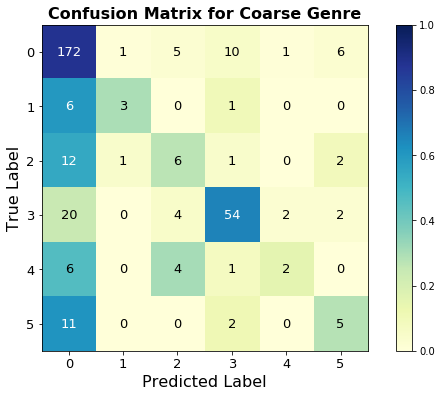

In [15]:
# NOT RIGHT!!! Need to draw cm for each class

y_pred_1 = np.argmax(y_pred_f1, axis=1)
y_test_1 = np.argmax(y_test, axis=1)
plot_confusion_matrix(y_test_1, y_pred_1)

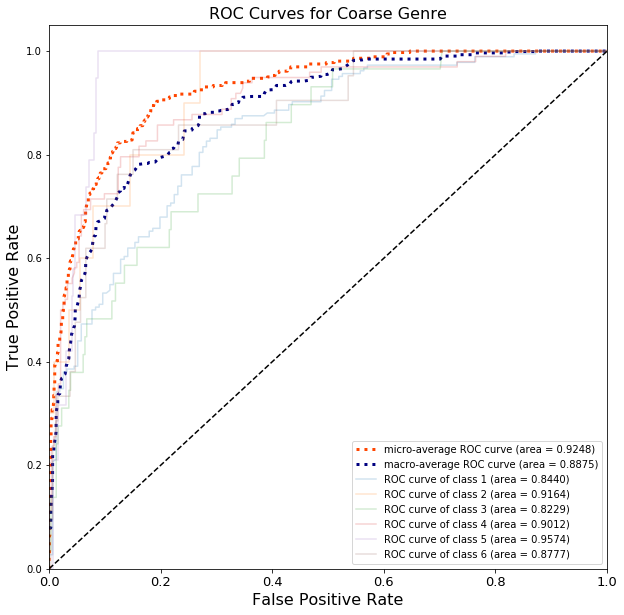

In [16]:
plot_roc_curve(y_test, np.average(predictions, axis=0), title='ROC Curves for Coarse Genre', micro=True, per_class=True)

In [17]:
predictions = []
for i in range(3):
    X_train, y_train, X_valid, y_valid, X_test, y_test, embedding_layer = main(beeap_1, '../input/glove-6b/glove.6B.300d.txt', data_index=[data_index['train'][i], data_index['val'][i], data_index['test']], content_column='Contents', label_column=[str(i+1) for i in range(6)])
    model =  build_lstm_model(X_train, y_train, X_valid, y_valid, arguments)
    pred = model.predict(X_test, batch_size = arguments['batch_size'], verbose = 1)
    predictions += [pred]

2685it [00:00, 13469.96it/s]

Loading word vectors...


400000it [00:32, 12479.17it/s]


Found 400000 word vectors.
Loading in comments...
max sequence length: 36540
min sequence length: 58
median sequence length: 303
Found 26969 unique tokens.
Shape of data tensor: (34040, 200)
Filling pre-trained embeddings...
Building model...
Train on 34040 samples, validate on 227 samples
Epoch 1/50
34040/34040 [==============================] - 7s 193us/step - loss: 0.2880 - acc: 0.8840 - val_loss: 0.2935 - val_acc: 0.8759

 ROC-AUC - epoch: 1 - score: 0.848114

Epoch 00001: val_loss improved from inf to 0.29352, saving model to best_model.hdf5
Epoch 2/50
34040/34040 [==============================] - 5s 135us/step - loss: 0.1084 - acc: 0.9604 - val_loss: 0.3603 - val_acc: 0.8847

 ROC-AUC - epoch: 2 - score: 0.870769

Epoch 00002: val_loss did not improve from 0.29352
Epoch 3/50
34040/34040 [==============================] - 5s 133us/step - loss: 0.0506 - acc: 0.9830 - val_loss: 0.4334 - val_acc: 0.8847

 ROC-AUC - epoch: 3 - score: 0.860312

Epoch 00003: val_loss did not improve fr

2071it [00:00, 10408.16it/s]

Loading word vectors...


400000it [00:33, 11829.72it/s]


Found 400000 word vectors.
Loading in comments...
max sequence length: 36540
min sequence length: 58
median sequence length: 296
Found 25931 unique tokens.
Shape of data tensor: (34040, 200)
Filling pre-trained embeddings...
Building model...
Train on 34040 samples, validate on 227 samples
Epoch 1/50
34040/34040 [==============================] - 7s 215us/step - loss: 0.3165 - acc: 0.8697 - val_loss: 0.2680 - val_acc: 0.9060

 ROC-AUC - epoch: 1 - score: 0.817760

Epoch 00001: val_loss improved from inf to 0.26800, saving model to best_model.hdf5
Epoch 2/50
34040/34040 [==============================] - 5s 136us/step - loss: 0.1166 - acc: 0.9575 - val_loss: 0.3802 - val_acc: 0.8943

 ROC-AUC - epoch: 2 - score: 0.800568

Epoch 00002: val_loss did not improve from 0.26800
Epoch 3/50
34040/34040 [==============================] - 5s 134us/step - loss: 0.0570 - acc: 0.9803 - val_loss: 0.5110 - val_acc: 0.8965

 ROC-AUC - epoch: 3 - score: 0.789681

Epoch 00003: val_loss did not improve fr

1366it [00:00, 13656.59it/s]

Loading word vectors...


400000it [00:30, 12961.15it/s]


Found 400000 word vectors.
Loading in comments...
max sequence length: 33773
min sequence length: 58
median sequence length: 298
Found 26054 unique tokens.
Shape of data tensor: (34040, 200)
Filling pre-trained embeddings...
Building model...
Train on 34040 samples, validate on 227 samples
Epoch 1/50
34040/34040 [==============================] - 7s 216us/step - loss: 0.2996 - acc: 0.8797 - val_loss: 0.3005 - val_acc: 0.8818

 ROC-AUC - epoch: 1 - score: 0.840065

Epoch 00001: val_loss improved from inf to 0.30052, saving model to best_model.hdf5
Epoch 2/50
34040/34040 [==============================] - 5s 136us/step - loss: 0.1263 - acc: 0.9516 - val_loss: 0.3618 - val_acc: 0.8869

 ROC-AUC - epoch: 2 - score: 0.848068

Epoch 00002: val_loss did not improve from 0.30052
Epoch 3/50
34040/34040 [==============================] - 5s 134us/step - loss: 0.0639 - acc: 0.9777 - val_loss: 0.4410 - val_acc: 0.8825

 ROC-AUC - epoch: 3 - score: 0.836491

Epoch 00003: val_loss did not improve fr

In [19]:
train_pred = model.predict(X_train, batch_size = 1024, verbose = 1)
y_pred = pred_classes_f1(train_pred, y_train, np.average(predictions, axis=0))
print('macro F1 score: {0:0.4f}'.format(f1_score(y_test, y_pred, average='macro')))
print('micro F1 score: {0:0.4f}'.format(f1_score(y_test, y_pred, average='micro')))

34040/34040 [==============================] - 1s 29us/step
macro F1 score: 0.4999
micro F1 score: 0.6588


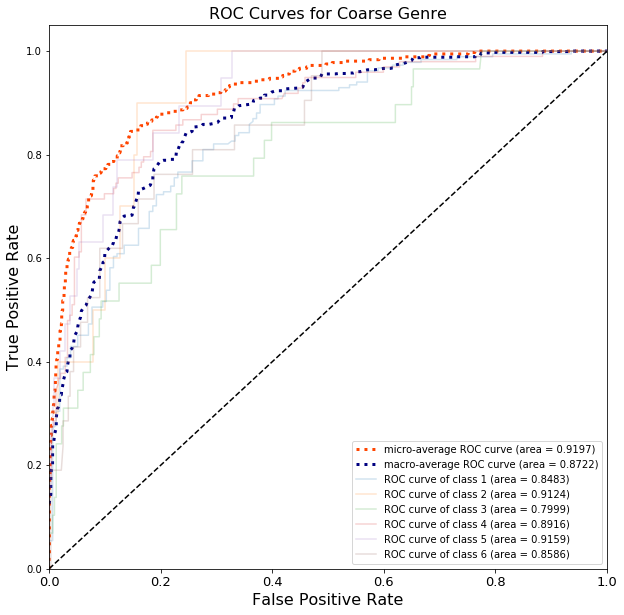

In [20]:
plot_roc_curve(y_test, np.average(predictions, axis=0), title='ROC Curves for Coarse Genre', micro=True, per_class=True)